# detecting polynomial classes from noisy data

The goal of this notebook is to interpret data in an x-y plane as a greyscale image. I want to use compare traditional MLPs with CNNs to classify unseen data and also check what happens if we confront the network with an unseen category of data. We go up to polynomials of degree 5 and randomly dice they coefficients. This can produce data that is pretty diverse.

## Training Data

The following function uses numpy to generate the data set. We make the output ndarray's shape configurable, but will stick with a 64x64 shaped plane that spans $x=(-32,32]$ or something alike.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def syn_image(x, values, yrange = None, shape = (32,32), value_span = (-1,1)):
    
    if type(yrange) == type(None):
        yrange = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[0])
        
    current = np.zeros(shape)
    for ix in range(len(x)):
        yval = values[ix]
        xval = x[ix]
        if yval >= value_span[0] and yval <= value_span[-1]:
            yidx = len(x) -1 - np.searchsorted(yrange, yval, side="left")
            current[yidx,len(x) -1 - ix] = 1
            
    return current

def polynomials_as_images(size, max_degree, shape = (32,32), value_span = (-1,1), seed = 1, smear_sd = None):
    
    if seed:
        np.random.seed(seed)
        
    size = int(size)
    x = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[-1])
    y = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[0])
    
    data   = np.zeros((size,int(shape[0]),int(shape[1])),
                       dtype=np.uint8)
    labels = np.random.randint(low=1,high=max_degree+1,size=size)
    
    for i in range(size):
        deg = labels[i]
        c   = np.random.random_sample(deg)
        #print(c)
        #print(x)
        values   = np.polynomial.polynomial.polyval(x,c)
        if smear_sd:
            smear_by = np.random.normal(1.,smear_sd,size=values.size)
            values = values*smear_by
        current = syn_image(x,values,y,shape,value_span)
            
        data[i,] = current
     
    return data, labels

In [3]:
train, labs = polynomials_as_images(20000,5,smear_sd=None)


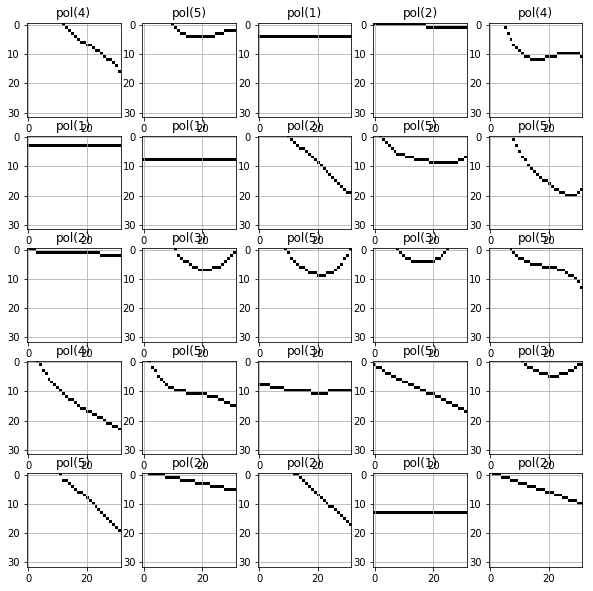

In [15]:
#nicer plots with axis labels etc
def plot_images(data, labels,  n_images = 25):
    xticks = np.linspace(start=1, stop=-1,num=3)
    yticks = np.linspace(start=1, stop=-1,num=3)

    plt.figure(figsize=(10,10))
    for i in range(n_images):
        ax = plt.subplot(5,5,i+1)
        #plt.xticks([])
        #plt.yticks([])
        plt.grid(True)
        plt.imshow(data[i], cmap=plt.cm.binary)
        #ax.xlabel("pol({0})".format(labs[i]),color='white')
        ax.set_title("pol({0})".format(labs[i]))
        
        
plot_images(train, labs)

In [16]:
#MLP comes here with non-linearity
from keras.utils import to_categorical
labels = to_categorical(labs)

from keras import Sequential
from keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(Flatten(input_shape=(32,32)))
model.add(Dense(64, activation='relu'))#all to all relation ship in first hidden layer
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
__________

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']
             )

hist = model.fit(train, labels, epochs=20,validation_split = .05)

Train on 19000 samples, validate on 1000 samples
Epoch 1/20
19000/19000 [==============================] - 2s 128us/step - loss: 1.2421 - acc: 0.4202 - val_loss: 0.9397 - val_acc: 0.5630
Epoch 2/20
19000/19000 [==============================] - 2s 115us/step - loss: 0.9360 - acc: 0.5627 - val_loss: 0.8105 - val_acc: 0.6100
Epoch 3/20
19000/19000 [==============================] - 2s 104us/step - loss: 0.8516 - acc: 0.6129 - val_loss: 0.7499 - val_acc: 0.6610
Epoch 4/20
19000/19000 [==============================] - 2s 106us/step - loss: 0.7991 - acc: 0.6466 - val_loss: 0.7185 - val_acc: 0.6820
Epoch 5/20
19000/19000 [==============================] - 2s 96us/step - loss: 0.7625 - acc: 0.6660 - val_loss: 0.6969 - val_acc: 0.6940
Epoch 6/20
19000/19000 [==============================] - 2s 97us/step - loss: 0.7287 - acc: 0.6855 - val_loss: 0.6927 - val_acc: 0.6910
Epoch 7/20
19000/19000 [==============================] - 2s 98us/step - loss: 0.6949 - acc: 0.6990 - val_loss: 0.6741 - val_

In [11]:
#CNN
from keras.layers import Conv2D, MaxPooling2D

train_ = train.reshape(train.shape[0],train.shape[1],train.shape[2],1)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=(32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(6, activation='softmax'))

cnn.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
__________

In [12]:
cnn.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']
             )

chist = cnn.fit(train_, labels, epochs=20,
                  validation_split = .05)

(20000, 32, 32, 1)
Train on 19000 samples, validate on 1000 samples
Epoch 1/20
19000/19000 [==============================] - 22s 1ms/step - loss: 0.9636 - acc: 0.5634 - val_loss: 0.7038 - val_acc: 0.7200
Epoch 2/20
19000/19000 [==============================] - 23s 1ms/step - loss: 0.6979 - acc: 0.6971 - val_loss: 0.6360 - val_acc: 0.7470
Epoch 3/20
19000/19000 [==============================] - 23s 1ms/step - loss: 0.6408 - acc: 0.7243 - val_loss: 0.5785 - val_acc: 0.7710
Epoch 4/20
19000/19000 [==============================] - 20s 1ms/step - loss: 0.6043 - acc: 0.7508 - val_loss: 0.5450 - val_acc: 0.7950
Epoch 5/20
19000/19000 [==============================] - 23s 1ms/step - loss: 0.5739 - acc: 0.7667 - val_loss: 0.5065 - val_acc: 0.8160
Epoch 6/20
19000/19000 [==============================] - 21s 1ms/step - loss: 0.5555 - acc: 0.7742 - val_loss: 0.4914 - val_acc: 0.8110
Epoch 7/20
19000/19000 [==============================] - 24s 1ms/step - loss: 0.5396 - acc: 0.7828 - val_loss

In [13]:
def plot_loss_acc(hist):
    fig = plt.figure(figsize=(15,4));
  
    ax = fig.add_subplot(121)
    ax.semilogy(hist.epoch,hist.history['loss'],hist.history['val_loss'])
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(['train','val/test'],loc='upper right')
    ax.grid(True)

    ax = fig.add_subplot(122)
    ax.plot(hist.epoch,hist.history['acc'],hist.history['val_acc'])
    ax.set_ylim([0.,1.])
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.legend(['train','val/test'],loc='lower right')
    ax.grid(True)

In [14]:
print("MLP")
plot_loss_acc(hist)
print("ConvNet")
plot_loss_acc(chist)

MLP


NameError: name 'hist' is not defined

## 